# Cleaning Reddit Datasets
Defines a bunch of cleaning functions and general guidelines for keeping datasets consistent across notebooks 
Functions are designed to be able to easily change what gets cleaned, per Tim's guidelines of be able to change pipeline quickly



# Import all you stuff

In [3]:
%load_ext dotenv
%dotenv

import numpy as np
import csv as csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
import json
import os
from datetime import datetime
import seaborn as sns
import re

from nltk import pos_tag
from nltk.util import pad_sequence
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from termcolor import colored

import praw
import requests
import json
import os
import glob
import calendar

from sklearn.model_selection import train_test_split


client_id = os.environ.get("client_id")
client_secret = os.environ.get("client_secret")
user_agent = os.environ.get("user_agent")

reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)


# # get to data folder
# try:
#     os.chdir('../data/')
#     print('changed directory to ../data/')
# except OSError:
#     print('directory already ../data/')

os.chdir('/homes/gws/taugust/ARK/community_guidelines/')

# check for if we want to be exporting currently
EXPORTING = True 
THRESHOLD_WORD_COUNT = 15
# YEAR = 2017 # THIS isn't used yet, but it would sure be useful


# Cleaning posts - Changed to 2018

In [219]:
### get data for all comments and posts written to subreddits tested for 2017
# df_posts = pd.read_csv('data/test_subs_2017/test_sub_posts_2017.csv')
df_posts = pd.read_csv('data/subs_2018/reddit_sub_posts_2018_000000000000.csv')

print('original number of posts:', len(df_posts))

### clean the data
df_posts_cleaned = df_posts.copy()

### drop any nan text
df_posts_cleaned = df_posts_cleaned.dropna(subset=['title']) # added and hasnt been run

### replace any nan text with '' - need this for adding to fulltext later
df_posts_cleaned[['title', 'selftext']] = df_posts_cleaned[['title', 'selftext']].fillna(' ')

# creating new columns 
# create a full text column for both the title and selftext
df_posts_cleaned['fulltext'] = df_posts_cleaned['title'] + df_posts_cleaned['selftext']

# create a month column 
df_posts_cleaned['created_month'] = df_posts_cleaned['created_utc'].apply(lambda x: datetime.fromtimestamp(x).month)

### break up the string into words -- takes a little while
### NOTE this isn't word_tokenize since that takes way too long, this is a poor-man's solution,
### words and word_count will not be perfect, but will provide a rough estimate that will have to be good enough
df_posts_cleaned['words'] = df_posts_cleaned['fulltext'].apply(lambda x: x.split(' '))

### get word counts 
df_posts_cleaned['word_count'] = df_posts_cleaned['words'].apply(len)

### get only comments with more than 10 (giving a little lee-way rather than >=) words:
df_posts_cleaned =  df_posts_cleaned[df_posts_cleaned['word_count'] > THRESHOLD_WORD_COUNT]
print('number of posts greater than ', THRESHOLD_WORD_COUNT ,' words:', len(df_posts_cleaned))

### replace any characters that could mess up the csv writing 
df_posts_cleaned.fulltext = df_posts_cleaned.fulltext.apply(lambda line: re.sub('\\\\', '', line))
df_posts_cleaned.title = df_posts_cleaned.title.apply(lambda line: re.sub('\\\\', '', line))
df_posts_cleaned.selftext = df_posts_cleaned.selftext.apply(lambda line: re.sub('\\\\', '', line))


### remove any deleted or removed posts
df_posts_cleaned = df_posts_cleaned[df_posts_cleaned['selftext'].apply(lambda x: x not in ['[deleted]', '[removed]'])]
print('number of non-deleted/removed posts:', len(df_posts_cleaned))

### seperate moderator posts
df_posts_cleaned_mod = df_posts_cleaned[df_posts_cleaned['distinguished'] == 'moderator'].copy()
print('number of moderator posts:', len(df_posts_cleaned_mod))
df_posts_cleaned = df_posts_cleaned[df_posts_cleaned['distinguished'] != 'moderator'].copy()
print('number of non-moderator posts:', len(df_posts_cleaned))

original number of posts: 942479
number of posts greater than  15  words: 175282
number of non-deleted/removed posts: 151923
number of moderator posts: 614
number of non-moderator posts: 151309


Text(0.5, 1.0, 'Count of posts by month')

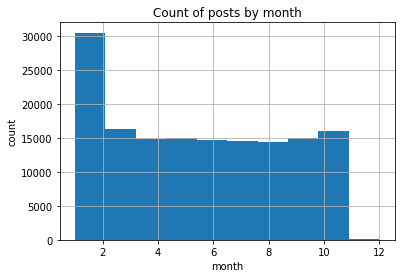

In [220]:

# Visualize all reddit data by month
ax = df_posts_cleaned['created_month'].hist()
ax.set_xlabel('month')
ax.set_ylabel('count')
ax.set_title('Count of posts by month')

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


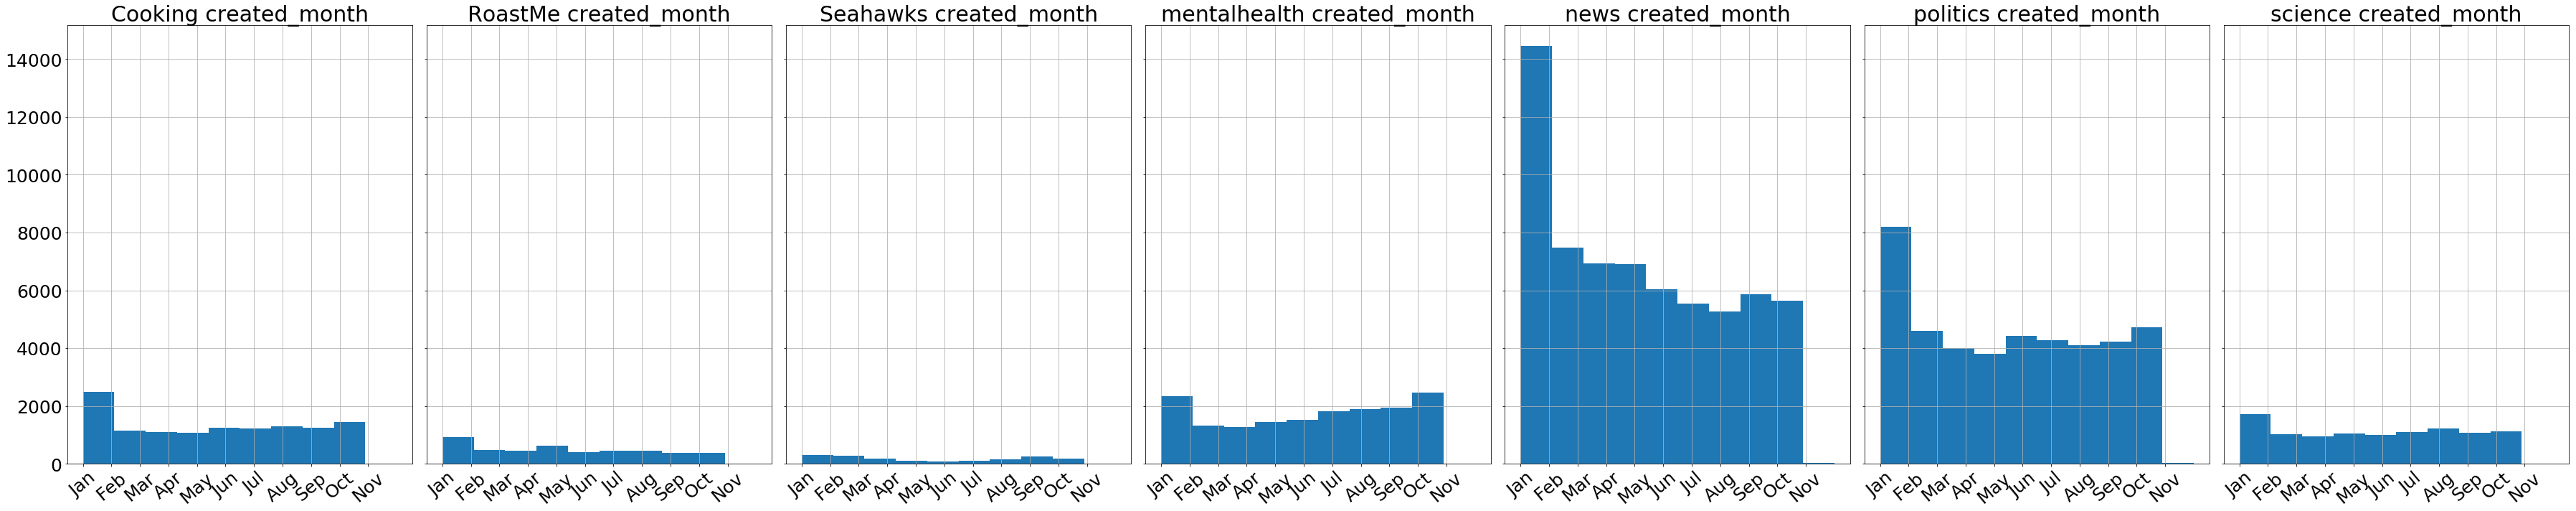

In [221]:
### visualize counts for each subreddit by month
def plot_multiple_hist(df, grouping, column, xlabels):
    groups = df.groupby(grouping)
    fig, axs = plt.subplots(1, len(groups), sharey=True, tight_layout=True)
    fig.set_figheight(10)
    fig.set_figwidth(50)
    for i, (sub, g) in enumerate(groups):
        g[column].hist(ax=axs[i])
        axs[i].set_title(sub + ' ' + column, fontsize=30)
        axs[i].set_xticks(range(1,12))
        axs[i].set_xticklabels(labels=xlabels, rotation=40)
        axs[i].tick_params(axis='both', which='major', labelsize=25)
    fig.show()

month_list = [calendar.month_abbr[i] for i in range(1,12)]
plot_multiple_hist(df_posts_cleaned, 'subreddit', 'created_month', month_list)


In [222]:
# ### Just testing how well the distribution works for test/train split
# plot_multiple_hist(df_posts_train, 'subreddit', 'created_month', month_list)
# plot_multiple_hist(df_posts_test, 'subreddit', 'created_month', month_list)


In [223]:
### export the data to a cleaned csv 
if EXPORTING:
    ### split into test and train
    df_posts_train, df_posts_test = train_test_split(df_posts_cleaned, test_size=0.1, random_state=100)

    df_posts_train.to_csv('data/cleaned/train/2018/posts/df_posts_train_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
    df_posts_test.to_csv('data/cleaned/test/2018/posts/df_posts_test_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
    
    df_posts_cleaned.to_csv('data/cleaned/cleaned_posts_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
    df_posts_cleaned_mod.to_csv('data/cleaned/cleaned_mod_posts_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')

In [225]:
# double check that posts read/write correctly
print('Double checking that posts write/read to csv correctly')
df_posts_cleaned_check = pd.read_csv('data/cleaned/cleaned_posts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
print(len(df_posts_cleaned), len(df_posts_cleaned_check)) 

Double checking that posts write/read to csv correctly


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11,21,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


151309 151309


# Cleaning comments - changed to 2018

In [7]:
### Get all csvs 
extension = 'csv'
all_comment_csvs = [i for i in glob.glob('data/subs_2018/comments/reddit_sub_comments_2018_*.{}'.format(extension))]

all_comment_csvs_2017 = [i for i in glob.glob('data/test_subs_2017/test_sub_comments_*.{}'.format(extension))]

print(len(all_comment_csvs))

9


In [8]:
### build full comments df
df_list = []

for csv_file in all_comment_csvs:
    df = pd.read_csv(csv_file,index_col=None, header=0)
    df_list.append(df)
    
df_comments = pd.concat(df_list, axis = 0, ignore_index = True)
print('original number of comments:', len(df_comments))

original number of comments: 28335829


In [9]:
### copy the data
df_comments_cleaned = df_comments.copy()


In [11]:
### take out any empty body posts
df_comments_cleaned = df_comments_cleaned.dropna(subset=['body']) # added and hasnt been run


In [12]:
### create a month column 
df_comments_cleaned['created_month'] = df_comments_cleaned['created_utc'].apply(lambda x: datetime.fromtimestamp(x).month)


In [13]:
### replace any nan text with ' ' for the text - don't really nead this
# df_comments_cleaned['body'] = df_comments_cleaned['body'].fillna(' ')


In [14]:
### break up the string into words -- takes a really long time
### NOTE (trying word_tokenize now) this isn't word_tokenize since that takes way too long, this is a poor-man's solution,
### words and word_count will not be perfect, but will provide a rough estimate that will have to be good enough
df_comments_cleaned['words'] = df_comments_cleaned['body'].apply(lambda x: x.split(' '))


In [15]:
### get word counts 
df_comments_cleaned['word_count'] = df_comments_cleaned['words'].apply(len)


In [16]:
### get only comments with more than 10 (giving a little lee-way rather than >=) words:
df_comments_cleaned =  df_comments_cleaned[df_comments_cleaned['word_count'] > THRESHOLD_WORD_COUNT]
print('number of comments greater than ', THRESHOLD_WORD_COUNT ,' words:', len(df_comments_cleaned))


number of comments greater than  15  words: 133649


In [19]:
### replace any characters that could mess up the csv writing 
df_comments_cleaned.body = df_comments_cleaned.body.apply(lambda line: re.sub('\\\\', '', line))


In [ ]:
### seperate automod comments out
df_comments_auto_mod = df_comments_cleaned[df_comments_cleaned['author'] == 'AutoModerator'].copy()
print('number of auto mod comments:', len(df_comments_auto_mod))


In [ ]:
### NOT DONE: seperate deleted posts
df_comments_deleted = df_comments_cleaned[df_comments_cleaned['author'] == '[deleted]'].copy()
print('number of deleted comments:', len(df_comments_deleted))


In [239]:
### remove all deleted or removed posts
df_comments_cleaned = df_comments_cleaned[df_comments_cleaned['author'].apply(lambda x: x not in ['[deleted]', 'AutoModerator'])].copy()
print('number of comments w/o autmod and deleted:', len(df_comments_cleaned))


number of comments w/o autmod and deleted: 18253578


In [240]:
### get all mod posts
df_comments_mod = df_comments_cleaned[df_comments_cleaned['distinguished'].apply(lambda x: x in ['moderator', 'admin'])].copy()
print('number of mod and admin comments (not automod)', len(df_comments_mod))


number of mod and admin comments (not automod) 102626


In [20]:
### remove all mod/admin posts
df_comments_cleaned = df_comments_cleaned[df_comments_cleaned['distinguished'].apply(lambda x: x not in ['moderator', 'admin'])].copy()
print('number of non-mod and admin comments', len(df_comments_cleaned))



number of non-mod and admin comments 133518


In [23]:
### seperate words into a diff dataframe for export reasons
# df_words = df_comments_cleaned[['words', 'id']].copy()

df_comments_cleaned = df_comments_cleaned.drop('words', axis=1)

KeyError: "['words'] not found in axis"

In [243]:
### Export
if EXPORTING:
    # fixing weird word count issue
    cols = df_comments_cleaned.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_comments_cleaned = df_comments_cleaned[cols]
    
    ### split into test and train
    df_comments_train, df_comments_test = train_test_split(df_comments_cleaned, test_size=0.1, random_state=100)
    
    df_comments_cleaned.to_csv('data/cleaned/cleaned_comments_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
    df_comments_train.to_csv('data/cleaned/train/2018/comments/df_comments_train_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
    df_comments_test.to_csv('data/cleaned/test/2018/comments/df_comments_test_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')

#     df_words.to_csv('cleaned/cleaned_comments_words_2017.csv')
#     df_comments_mod.to_csv('data/cleaned/cleaned_mod_comments_2017.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
#     df_comments_auto_mod.to_csv('data/cleaned/cleaned_auto_mod_comments_2017.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
    df_comments_deleted.to_csv('data/cleaned/cleaned_comments_deleted_2017.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')



In [ ]:
# double check that comments read/write correctly
print('Double checking that comments write/read to csv correctly')
df_comments_cleaned_check = pd.read_csv('data/cleaned/cleaned_comments_2017.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
print(len(df_comments_cleaned), len(df_comments_cleaned_check))

In [ ]:
### Visualize subreddit based on number of author comments per author -- not working
df_comments['author_count'] = df_comments.groupby(['author'])['body'].transform('count') 
sub_groups = df_comments_cleaned.groupby('subreddit')
fig, axs = plt.subplots(len(sub_groups), 1, sharex=True, tight_layout=True)
fig.set_figheight(25)
fig.set_figwidth(50)
for i, (sub, g) in enumerate(sub_groups):
        axs[i].set_title(sub + ' authors', fontsize=30)
        author_count = g.groupby(['author']).agg('count')
        sns.violinplot(x='body', data=author_count, ax=axs[i])
        axs[i].set_xlim(0, 200)


In [195]:
# len_test = 0
# len_check = 0
# import re

# while len_test == len_check:
#     df_comments_cleaned_test = df_comments_cleaned.iloc[:1000000].sample(100000)
#     df_comments_cleaned_test.body.apply(lambda line: re.sub('\\\\', '', line))
#     df_comments_cleaned_test.to_csv('data/cleaned/cleaned_comments_2017_test.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
#     df_comments_cleaned_check_test = pd.read_csv('data/cleaned/cleaned_comments_2017_test.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
    
#     len_test = len(df_comments_cleaned_test)
#     len_check = len(df_comments_cleaned_check_test)
#     print(len_test, len_check)

In [194]:
# df_comments_cleaned_check_test[pd.isnull(df_comments_cleaned_check_test['body'])]

In [193]:

# display(df_comments_cleaned_check_test.iloc[62271:62274])
# df_comments_cleaned_check_test.iloc[62271].body

In [192]:
# display(df_comments_cleaned_test.iloc[62271:62274])
# df_comments_cleaned_test.iloc[62271].body

# Combining posts + comments
[optional] combine posts and comments into a single df to run in the SLMs, author counts will then be for combined posting and commenting


In [244]:
comment_cols = ['body', 'author', 'subreddit_id', 'subreddit', 'created_month', 'word_count', 'kind']
post_cols = ['fulltext', 'author', 'subreddit_id', 'subreddit', 'created_month', 'word_count', 'kind']

# since we don;t necessarily use this notebook linearly, 
# if the cleaned comments and posts don't exist yet, reload them
try:     
    df_posts_cleaned['kind'] = 'post'
    df_comments_cleaned['kind'] = 'comment'
except:
    print('reloading comments and posts...', end='')
    df_posts_cleaned = pd.read_csv('cleaned/posts_cleaned_2018.csv')
    df_comments_cleaned = pd.read_csv('cleaned/cleaned_comments_2018.csv')
    print('Done')


df_posts_comments = df_comments_cleaned[comment_cols].append(df_posts_cleaned[post_cols].rename(index=str, columns={'fulltext': 'body'}))

In [245]:
len(df_posts_comments), len(df_comments_cleaned) 

(18302261, 18150952)

# Break up into subreddits

In [246]:
### currently ignoring the train/test split
def export_subreddits(df, path, ext):
    sub_groups = df.groupby('subreddit')
    for sub, group in sub_groups:
        # rearrange columns to deal with weird word count issue
        cols = group.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        group = group[cols]
        save_path = path+sub+ext
        print('Exporting', colored(save_path, 'magenta'), '......', end=' ')
        if EXPORTING:
            group.to_csv(save_path,index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
        else: 
            display(group)
        print('Done')

### comments

In [247]:
export_subreddits(df_comments_cleaned,path='data/cleaned/sub_comments/', ext='_comments_2018.csv')

Exporting data/cleaned/sub_comments/Cooking_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/RoastMe_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/Seahawks_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/mentalhealth_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/news_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/politics_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/science_comments_2018.csv ...... Done


### posts

In [248]:
export_subreddits(df_posts_cleaned,path='data/cleaned/sub_posts/', ext='_posts_2018.csv')

Exporting data/cleaned/sub_posts/Cooking_posts_2018.csv ...... Done
Exporting data/cleaned/sub_posts/RoastMe_posts_2018.csv ...... Done
Exporting data/cleaned/sub_posts/Seahawks_posts_2018.csv ...... Done
Exporting data/cleaned/sub_posts/mentalhealth_posts_2018.csv ...... Done
Exporting data/cleaned/sub_posts/news_posts_2018.csv ...... Done
Exporting data/cleaned/sub_posts/politics_posts_2018.csv ...... Done
Exporting data/cleaned/sub_posts/science_posts_2018.csv ...... Done


### Combined

In [250]:
export_subreddits(df_posts_comments,path='data/cleaned/sub_combined/2018/', ext='_combined_2018.csv')

Exporting data/cleaned/sub_combined/2018/Cooking_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/RoastMe_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/Seahawks_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/mentalhealth_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/news_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/politics_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/science_combined_2018.csv ...... Done


In [251]:
len(df_posts_comments), len(df_comments_cleaned)

(18302261, 18150952)

# Author Count Functions
Simple functions for import/export and extracting author counts

In [4]:
### function to return df with author counts for each month
def get_author_counts(df):
    author_counts = df.groupby(['created_month'])['author'].value_counts()
    author_counts = pd.DataFrame(author_counts).reset_index(0)
    author_counts.columns = ['created_month', 'count']
    
    # added for ease of importing
    author_counts['created_month'] = author_counts['created_month'].astype(int)

    month_groups = author_counts.groupby('created_month')
    for m, g in month_groups:
        author_counts[m] = g['count']
    
    author_counts = author_counts.fillna(0)
    
    # reset index now since we don't need authors to be an index for joining counts above
    author_counts = author_counts.reset_index()
    
    # also drop all the duplicates + unnecessary cols that this made
    author_counts = author_counts.drop_duplicates(subset=['author'])
    author_counts.drop(['created_month', 'count'], axis=1, inplace=True)
    
    return author_counts



# getting number of authors who posted at least one each month
def plot_author_counts(df_author_counts, ax, sub_name):
    counts = df_author_counts[range(1,13)].apply(lambda col: col.apply(lambda row: row > 0).sum(), axis=0)
    sns.barplot(x = counts.index, y=counts, ax=ax)
    axs[i].set_title(sub + 'author counts', fontsize=30)
    axs[i].set_xticks(range(1,12))
    axs[i].tick_params(axis='both', which='major', labelsize=25)
    
    
def export_author_counts(sub_name, df, path, ext, split_size=0.3, combined=True):
    print('Extracting author counts for', colored(sub_name, 'magenta'), '.....')
    
    print(len(df))
    # split df if combining 
    if combined:
        print(len(df[df['kind'] == 'comment']))
        df_post_author_counts = get_author_counts(df[df['kind'] == 'post'])
        df_post_author_counts['kind'] = 'post'
        df_comment_author_counts = get_author_counts(df[df['kind'] == 'comment'])
        df_comment_author_counts['kind'] = 'comment'
        author_counts = df_comment_author_counts.append(df_post_author_counts)
    else:
        author_counts = get_author_counts(df)
        
    ### split into test and train
    author_counts_train, author_counts_test = train_test_split(author_counts, test_size=split_size, random_state=100)
    
    # plotting both
#     fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#     plot_author_counts(author_counts_train, axs[0], sub_name+'_train')
#     plot_author_counts(author_counts_test, axs[1], sub_name+'_test')
    
#     fig.show()

    author_count_path_train = 'data/cleaned/train/2018/'+'author_counts/'+sub_name+'_author_counts_train'+ext
    author_count_path_test = 'data/cleaned/test/2018/'+'author_counts/'+sub_name+'_author_counts_test'+ext
    author_count_path = 'data/cleaned/sub_author_counts/'+sub_name+'_author_counts'+ext

    
    if EXPORTING:
        print('Exporting ', colored(author_count_path, 'magenta'),'.....', end='')
        author_counts.to_csv(author_count_path, index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
        print('Done')
        
        print('Exporting ', colored(author_count_path_train, 'magenta'),'.....', end='')
        author_counts_train.to_csv(author_count_path_train, index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
        print('Done')
        
        print('Exporting ', colored(author_count_path_test, 'magenta'),'.....', end='')
        author_counts_test.to_csv(author_count_path_test, index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
        print('Done')
    else:
        display(author_counts)
# Import comments and export author counts for a given sub NOTE THIS IS COMBINED
def import_export_author_counts(sub_name, path='data/cleaned/sub_combined/2018/', ext='_2018.csv'):
    df_path = path+sub_name+'_combined'+ext
    print('Importing', colored(df_path, 'magenta'), '.....')
    df = pd.read_csv(df_path, quoting=csv.QUOTE_ALL, escapechar='\\')
    export_author_counts(sub_name, df, path, ext)
        



## Author Counts 
Actually running functions on some subreddits

In [8]:
df_posts_cleaned = pd.read_csv('data/cleaned/cleaned_posts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\')

# sub_groups = df_comments_cleaned.groupby('subreddit')

subreddits = df_posts_cleaned['subreddit'].unique()
EXPORTING = True
for sub in subreddits:
    print(sub)
    import_export_author_counts(sub)



/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11,21,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cooking
Importing data/cleaned/sub_combined/2018/Cooking_combined_2018.csv .....
Extracting author counts for Cooking .....
293177
280891


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Exporting  data/cleaned/sub_author_counts/Cooking_author_counts_2018.csv .....Done
Exporting  data/cleaned/train/2018/author_counts/Cooking_author_counts_train_2018.csv .....Done
Exporting  data/cleaned/test/2018/author_counts/Cooking_author_counts_test_2018.csv .....Done
mentalhealth
Importing data/cleaned/sub_combined/2018/mentalhealth_combined_2018.csv .....
Extracting author counts for mentalhealth .....
98903
82878
Exporting  data/cleaned/sub_author_counts/mentalhealth_author_counts_2018.csv .....Done
Exporting  data/cleaned/train/2018/author_counts/mentalhealth_author_counts_train_2018.csv .....Done
Exporting  data/cleaned/test/2018/author_counts/mentalhealth_author_counts_test_2018.csv .....Done
Seahawks
Importing data/cleaned/sub_combined/2018/Seahawks_combined_2018.csv .....
Extracting author counts for Seahawks .....
125051
123395
Exporting  data/cleaned/sub_author_counts/Seahawks_author_counts_2018.csv .....Done
Exporting  data/cleaned/train/2018/author_counts/Seahawks_autho

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


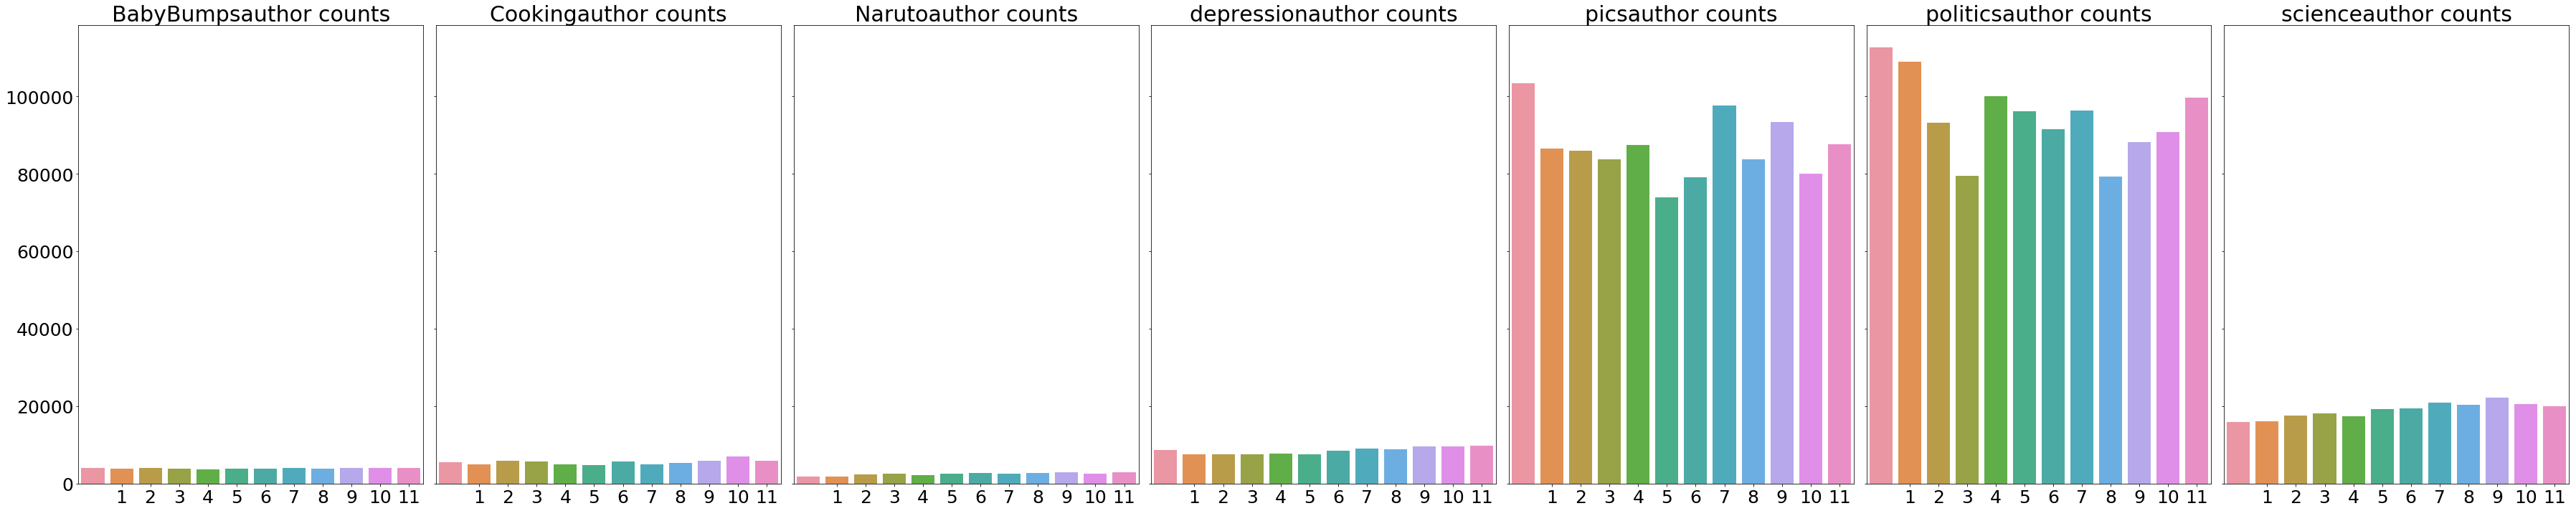

In [71]:

    
sub_groups = df_comments_cleaned.groupby('subreddit')
fig, axs = plt.subplots(1, len(sub_groups), sharey=True, tight_layout=True)
fig.set_figheight(10)
fig.set_figwidth(50)
for i, (sub, g) in enumerate(sub_groups):
    author_counts = get_author_counts(g)
    plot_author_counts(author_counts, axs[i], sub)
        


# Vocab saving
Build a text file containing all words to build a vocab for our language model